<a href="https://colab.research.google.com/github/yyduyuxuan/Machine-Learning-for-Data-Driven-Inventory-Replenishment-Evidence-from-the-M5-Retail-Dataset/blob/main/Error_Comparison_(Sum_Demand).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import os, sys, gc, time, warnings, pickle, psutil, random
from math import ceil
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
err_ml = pd.read_pickle("/content/drive/MyDrive/Colab Notebooks/Supervised Project/ML/df_eval_target_1ytest.pkl")
err_baseline = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Supervised Project/Baseline_Forecast/err_adapt.csv')
display(err_ml.head())
display(err_baseline.head())

,SeriesName,RMSE,Norm_RMSE,ME,Norm_ME,RMSSE,note
0,FOODS_1_219_TX_3,2.851631,1.284486,-0.530450,-0.238936,1.495669,None
1,FOODS_3_476_TX_1,4.548848,0.456921,-0.630871,-0.063370,1.034208,None
2,FOODS_1_219_WI_3,3.374027,0.883498,-0.555561,-0.145475,1.008858,None
3,FOODS_2_222_TX_1,3.199916,0.490927,-0.285455,-0.043794,1.112819,None
4,HOUSEHOLD_1_440_CA_1,1.807750,0.523373,0.019949,0.005776,0.749329,None


,Unnamed: 0,SeriesName,Model,RMSE,Norm_RMSE,ME,Norm_ME,RMSSE,note
0,0,FOODS_1_145_CA_1,AutoARIMA,3.610356,0.655933,0.098940,0.017976,1.313037,NaN
1,1,FOODS_1_145_CA_1,CrostonClassic,3.783855,0.687454,0.198284,0.036024,1.376137,NaN
2,2,FOODS_1_145_CA_1,SeasonalNaive,5.056468,0.918664,0.083102,0.015098,1.838969,NaN
3,3,FOODS_1_145_CA_1,Theta,3.753326,0.681908,0.000654,0.000119,1.365034,NaN
4,4,FOODS_1_145_CA_3,AutoARIMA,3.500059,0.654674,0.079180,0.014810,1.038242,NaN


In [ ]:
demand_typ = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Supervised Project/Baseline_Forecast/df_long_1ytest.csv')
display(demand_typ.head())

,Unnamed: 0,unique_id,item_id,store_id,state_id,dept_id,d,date,sales,ADI,CV2,Demand_Type
0,0,FOODS_1_145_CA_1,FOODS_1_145,CA_1,CA,FOODS_1,883,2013-06-29,0,2.412358,0.45293,Intermittent
1,1,FOODS_1_145_CA_1,FOODS_1_145,CA_1,CA,FOODS_1,884,2013-06-30,0,2.412358,0.45293,Intermittent
2,2,FOODS_1_145_CA_1,FOODS_1_145,CA_1,CA,FOODS_1,885,2013-07-01,0,2.412358,0.45293,Intermittent
3,3,FOODS_1_145_CA_1,FOODS_1_145,CA_1,CA,FOODS_1,886,2013-07-02,3,2.412358,0.45293,Intermittent
4,4,FOODS_1_145_CA_1,FOODS_1_145,CA_1,CA,FOODS_1,887,2013-07-03,2,2.412358,0.45293,Intermittent


In [ ]:
# Merge baseline and ml results

common_cols = ['SeriesName','Model','RMSE','Norm_RMSE','ME','Norm_ME','RMSSE','note']

err_baseline_std = err_baseline[common_cols].copy()

# add Model='ML'
err_ml_std = (
    err_ml.rename(columns={c:c for c in err_ml.columns})
         .assign(Model='ML')[['SeriesName','Model','RMSE','Norm_RMSE','ME','Norm_ME','RMSSE','note']]
)


map_type = demand_typ[['unique_id','Demand_Type']].drop_duplicates()

err_baseline_std = (
    err_baseline_std
      .merge(map_type, left_on='SeriesName', right_on='unique_id', how='left')
      .drop(columns=['unique_id'])
)

err_ml_std = (
    err_ml_std
      .merge(map_type, left_on='SeriesName', right_on='unique_id', how='left')
      .drop(columns=['unique_id'])
)

# merge
err_all = pd.concat([err_baseline_std, err_ml_std], ignore_index=True)

err_all = err_all[['SeriesName','Demand_Type','Model','RMSE','Norm_RMSE','ME','Norm_ME','RMSSE','note']]

print("merge：", err_all.shape)
display(err_all.head())
print(err_all['Model'].value_counts())

合并后： (795, 9)


,SeriesName,Demand_Type,Model,RMSE,Norm_RMSE,ME,Norm_ME,RMSSE,note
0,FOODS_1_145_CA_1,Intermittent,AutoARIMA,3.610356,0.655933,0.098940,0.017976,1.313037,NaN
1,FOODS_1_145_CA_1,Intermittent,CrostonClassic,3.783855,0.687454,0.198284,0.036024,1.376137,NaN
2,FOODS_1_145_CA_1,Intermittent,SeasonalNaive,5.056468,0.918664,0.083102,0.015098,1.838969,NaN
3,FOODS_1_145_CA_1,Intermittent,Theta,3.753326,0.681908,0.000654,0.000119,1.365034,NaN
4,FOODS_1_145_CA_3,Lumpy,AutoARIMA,3.500059,0.654674,0.079180,0.014810,1.038242,NaN


Model
AutoARIMA         159
CrostonClassic    159
SeasonalNaive     159
Theta             159
ML                159
Name: count, dtype: int64


In [ ]:
model_order = ['ML', 'AutoARIMA', 'CrostonClassic', 'SeasonalNaive', 'Theta']

err_all['Model'] = pd.Categorical(err_all['Model'],
                                  categories=model_order,
                                  ordered=True)
err_all = (err_all
           .sort_values(['SeriesName', 'Model'])
           .reset_index(drop=True))

display(err_all.head(15))

,SeriesName,Demand_Type,Model,RMSE,Norm_RMSE,ME,Norm_ME,RMSSE,note
0,FOODS_1_145_CA_1,Intermittent,ML,3.287913,0.595540,-0.090838,-0.016453,1.195770,None
1,FOODS_1_145_CA_1,Intermittent,AutoARIMA,3.610356,0.655933,0.098940,0.017976,1.313037,NaN
2,FOODS_1_145_CA_1,Intermittent,CrostonClassic,3.783855,0.687454,0.198284,0.036024,1.376137,NaN
3,FOODS_1_145_CA_1,Intermittent,SeasonalNaive,5.056468,0.918664,0.083102,0.015098,1.838969,NaN
4,FOODS_1_145_CA_1,Intermittent,Theta,3.753326,0.681908,0.000654,0.000119,1.365034,NaN
5,FOODS_1_145_CA_3,Lumpy,ML,3.111144,0.584459,-0.005294,-0.000995,0.922876,None
6,FOODS_1_145_CA_3,Lumpy,AutoARIMA,3.500059,0.654674,0.079180,0.014810,1.038242,NaN
7,FOODS_1_145_CA_3,Lumpy,CrostonClassic,3.629833,0.678948,0.347136,0.064931,1.076738,NaN
8,FOODS_1_145_CA_3,Lumpy,SeasonalNaive,4.506382,0.842904,-0.024931,-0.004663,1.336753,NaN
9,FOODS_1_145_CA_3,Lumpy,Theta,3.569742,0.667708,-0.042284,-0.007909,1.058913,NaN


In [ ]:
err_all.to_csv('/content/drive/MyDrive/Colab Notebooks/Supervised Project/Results_Comparison/err_all.csv', index=False)

In [ ]:
err_all = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Supervised Project/Results_Comparison/err_all.csv')

In [ ]:
import pandas as pd
import numpy as np

df = err_all.copy()

agg_main = (
    df.groupby('Model')
      .apply(lambda g: pd.Series({
          'Mean_RMSSE'     : g['RMSSE'].mean(),
          'Median_RMSSE'   : g['RMSSE'].median(),
          'RMSSE_p90'      : g['RMSSE'].quantile(0.90),
          'RMSSE_IQR'      : g['RMSSE'].quantile(0.75) - g['RMSSE'].quantile(0.25),
          'Mean_RMSE'      : g['RMSE'].mean(),
          'Median_RMSE'    : g['RMSE'].median(),
          'RMSE_p90'       : g['RMSE'].quantile(0.90),
          'Bias_ME_mean'   : g['ME'].mean(),
          'Bias_ME_median' : g['ME'].median(),
      }))
      .reset_index()
      .sort_values(['Median_RMSSE','RMSSE_p90'])
)
agg_main

/tmp/ipython-input-189992700.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: pd.Series({


,Model,Mean_RMSSE,Median_RMSSE,RMSSE_p90,RMSSE_IQR,Mean_RMSE,Median_RMSE,RMSE_p90,Bias_ME_mean,Bias_ME_median
2,ML,1.256380,1.064192,1.663599,0.392650,5.258328,3.199916,11.943230,-0.783745,-0.159600
0,AutoARIMA,1.413221,1.221839,1.743911,0.398084,6.213992,3.422362,13.569155,-0.089791,-0.067897
4,Theta,1.421263,1.238803,1.712746,0.386472,6.304657,3.507465,13.591155,-0.214441,-0.074028
1,CrostonClassic,1.615649,1.370401,2.106438,0.553868,7.399804,3.959800,17.187118,0.807185,0.072233
3,SeasonalNaive,1.778610,1.554247,2.218332,0.564993,7.483785,4.336599,16.464957,-0.024094,-0.011080


In [ ]:
# Count the number of models with RMSSE < 1
count_rmsse_lt1 = (
    err_all[err_all['RMSSE'] < 1]
    .groupby('Model')['SeriesName']
    .count()
    .sort_values(ascending=False)
)

print(count_rmsse_lt1)

Model
ML                63
AutoARIMA         27
Theta             24
CrostonClassic    12
SeasonalNaive      6
Name: SeriesName, dtype: int64


/tmp/ipython-input-3761112632.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby('Model')['SeriesName']


**Store**

In [ ]:
df = err_all.copy()

df['Store'] = df['SeriesName'].str.extract(r'([A-Z]{2}_\d+)$')

cols_needed = ['SeriesName', 'Store', 'Model', 'RMSSE', 'RMSE', 'ME']
df = df[cols_needed].dropna(subset=['RMSSE'])

# Calculate win rate based on RMSSE by store（baseline vs ML）
piv = df.pivot_table(index=['SeriesName', 'Store'], columns='Model', values='RMSSE', aggfunc='first')

piv_valid = piv.dropna(subset=['ML'])

baseline_cols = [c for c in piv_valid.columns if c != 'ML']

wins_bool = {m: (piv_valid[m] < piv_valid['ML']) for m in baseline_cols}

wins_df = pd.DataFrame(wins_bool, index=piv_valid.index)

win_rate_store = (wins_df
                  .groupby(level='Store')
                  .mean()
                  .reset_index()
                  .rename(columns=lambda c: f'WinRate_{c}' if c in baseline_cols else c))

n_series_store = (piv_valid
                  .groupby(level='Store')
                  .size()
                  .rename('n_series')
                  .reset_index())

win_rate_store = win_rate_store.merge(n_series_store, on='Store', how='left')

for m in baseline_cols:
    win_rate_store[f'WinRate_{m}'] = (win_rate_store[f'WinRate_{m}'] * 100).round(1)

print("Store-level win rates vs ML (by RMSSE, %):")
print(win_rate_store.sort_values('Store'))

# Summary metrics by store × model (median/p90 RMSSE, median RMSE, average ME)
store_summary = (df.groupby(['Store','Model'])
                   .agg(Median_RMSSE=('RMSSE','median'),
                        RMSSE_p90   =('RMSSE', lambda x: x.quantile(0.90)),
                        Median_RMSE =('RMSE','median'),
                        ME_mean     =('ME','mean'))
                   .reset_index()
                   .sort_values(['Store','Median_RMSSE']))

print("\nStore × Model summary metrics:")
print(store_summary.head(20))

Store-level win rates vs ML (by RMSSE, %):
  Store  WinRate_AutoARIMA  WinRate_CrostonClassic  WinRate_SeasonalNaive  \
0  CA_1                5.0                     0.0                    0.0   
1  CA_3                5.0                     5.0                    0.0   
2  CA_4                5.0                     5.0                    0.0   
3  TX_1                0.0                     0.0                    0.0   
4  TX_2                5.0                     0.0                    0.0   
5  TX_3                5.0                     0.0                    0.0   
6  WI_1                0.0                     0.0                    0.0   
7  WI_3                0.0                     0.0                    0.0   

   WinRate_Theta  n_series  
0            5.0        20  
1           10.0        20  
2            5.0        20  
3           10.5        19  
4            5.0        20  
5            5.0        20  
6            0.0        20  
7            0.0        20  

S

In [ ]:
store_summary.head(20)

,Store,Model,Median_RMSSE,RMSSE_p90,Median_RMSE,ME_mean
2,CA_1,ML,1.076005,1.388784,3.333708,-0.595300
0,CA_1,AutoARIMA,1.215137,1.492675,3.536483,0.089480
4,CA_1,Theta,1.256510,1.470820,3.817149,-0.205129
1,CA_1,CrostonClassic,1.285188,1.815172,3.719361,0.803716
3,CA_1,SeasonalNaive,1.589717,1.986541,5.016433,-0.025762
7,CA_3,ML,1.018213,1.449561,4.996096,-1.030286
9,CA_3,Theta,1.220547,1.622475,6.224655,-0.244688
5,CA_3,AutoARIMA,1.237653,1.574910,6.251521,-0.204018
6,CA_3,CrostonClassic,1.279024,1.728250,6.885388,0.269164
8,CA_3,SeasonalNaive,1.530477,2.086727,7.338020,-0.040028


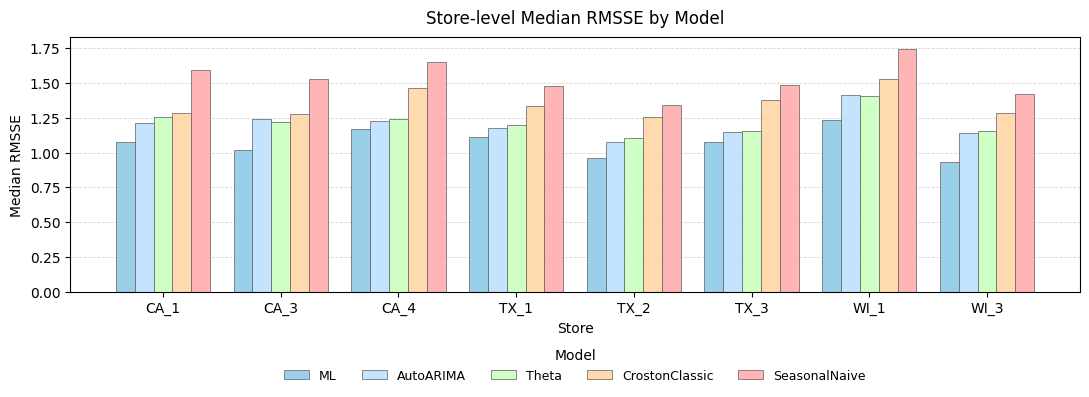

In [ ]:
# Draw a grouped histogram of Median_RMSSE by store × model
summary = (store_summary
           .pivot(index='Store', columns='Model', values='Median_RMSSE')
           .sort_index())

order = ['ML', 'AutoARIMA', 'Theta', 'CrostonClassic', 'SeasonalNaive']
order = [m for m in order if m in summary.columns]
summary = summary[order]

stores = summary.index.tolist()
models = summary.columns.tolist()
x = np.arange(len(stores))
width = 0.8 / len(models)

light_palette = {
    'ML'             : '#8ecae6',
    'AutoARIMA'      : '#bde0fe',
    'Theta'          : '#caffbf',
    'CrostonClassic' : '#ffd6a5',
    'SeasonalNaive'  : '#ffadad',
}
for m in models:
    light_palette.setdefault(m, '#d9d9d9')

fig, ax = plt.subplots(figsize=(11, 4.2))

for i, m in enumerate(models):
    ax.bar(
        x + i*width - (len(models)-1)*width/2,
        summary[m].values,
        width,
        label=m,
        color=light_palette[m],
        edgecolor='#666666',
        linewidth=0.6,
        alpha=0.9
    )

# Coordinates/Grid/Title
ax.set_xlabel('Store')
ax.set_ylabel('Median RMSSE')
ax.set_xticks(x)
ax.set_xticklabels(stores)
ax.set_title('Store-level Median RMSSE by Model', pad=10)

ax.yaxis.grid(True, linestyle='--', linewidth=0.6, alpha=0.5)
ax.set_axisbelow(True)

leg = ax.legend(
    title='Model',
    ncol=len(models),
    bbox_to_anchor=(0.5, -0.18),
    loc='upper center',
    frameon=False,
    fontsize=9
)

plt.tight_layout()
plt.show()

In [ ]:
store_best_model = (
    store_summary.loc[store_summary.groupby('Store')['Median_RMSSE'].idxmin(),
                      ['Store', 'Model', 'Median_RMSSE', 'RMSSE_p90']]
    .sort_values('Store')
    .reset_index(drop=True)
    .rename(columns={'Model': 'Best_Model',
                     'Median_RMSSE': 'Best_Median_RMSSE',
                     'RMSSE_p90': 'Best_RMSSE_p90'})
)

print("\nStore-level best model (lowest Median_RMSSE):")
display(store_best_model)


Store-level best model (lowest Median_RMSSE):


,Store,Best_Model,Best_Median_RMSSE,Best_RMSSE_p90
0,CA_1,ML,1.076005,1.388784
1,CA_3,ML,1.018213,1.449561
2,CA_4,ML,1.169099,1.758393
3,TX_1,ML,1.112819,1.463758
4,TX_2,ML,0.958886,1.550780
5,TX_3,ML,1.076629,1.438562
6,WI_1,ML,1.230783,1.788360
7,WI_3,ML,0.930174,1.694363


In [ ]:
# RMSE Rank
rmse_wide = (store_summary
             .pivot(index='Store', columns='Model', values='Median_RMSE')
             .sort_index())

order = ['ML', 'AutoARIMA', 'Theta', 'CrostonClassic', 'SeasonalNaive']
order = [m for m in order if m in rmse_wide.columns]
rmse_wide = rmse_wide[order]

rank_tbl = rmse_wide.rank(axis=1, method='min')
rank_tbl = rank_tbl.astype(int)

avg_rank_per_model = rank_tbl.mean(axis=0)
avg_rmse_per_model = rmse_wide.mean(axis=0)

overall_rank = rank_tbl.mean(axis=0).round(1).to_frame().T
overall_rank.index = ['Overall']

rank_final = pd.concat([rank_tbl, overall_rank], axis=0)

print("Ranking by Median_RMSE (1 = best):")
display(rank_final)

Ranking by Median_RMSE (1 = best):


Model,ML,AutoARIMA,Theta,CrostonClassic,SeasonalNaive
CA_1,1.0,2.0,4.0,3.0,5.0
CA_3,1.0,3.0,2.0,4.0,5.0
CA_4,1.0,3.0,2.0,5.0,4.0
TX_1,1.0,2.0,3.0,5.0,4.0
TX_2,1.0,2.0,3.0,4.0,5.0
TX_3,1.0,2.0,3.0,4.0,5.0
WI_1,1.0,2.0,3.0,4.0,5.0
WI_3,1.0,2.0,3.0,4.0,5.0
Overall,1.0,2.2,2.9,4.1,4.8


**Demand type**

In [ ]:
# Summarize by Demand_Type × Model
df = err_all.copy()

need = {'Demand_Type','Model','RMSSE','RMSE','ME'}
missing = need - set(df.columns)
if missing:
    raise ValueError(f"err_all is missing columns: {missing}")
by_type = (df
    .groupby(['Demand_Type','Model'], dropna=False)
    .agg(
        count        = ('SeriesName', 'count'),
        Median_RMSSE = ('RMSSE', 'median'),
        RMSSE_p90    = ('RMSSE', lambda x: x.quantile(0.90)),
        Median_RMSE  = ('RMSE', 'median'),
        ME_mean      = ('ME', 'mean')
    )
    .reset_index()
    .sort_values(['Demand_Type','Median_RMSSE'])
)

print("Demand_Type × Model summary:")
display(by_type)

Demand_Type × Model summary:


,Demand_Type,Model,count,Median_RMSSE,RMSSE_p90,Median_RMSE,ME_mean
2,Erratic,ML,12,0.891679,0.972492,4.861759,-0.987965
4,Erratic,Theta,12,1.013445,1.412025,6.169667,-0.267632
0,Erratic,AutoARIMA,12,1.029656,1.305738,6.561222,-0.164668
3,Erratic,SeasonalNaive,12,1.208601,1.579387,7.074751,-0.045476
1,Erratic,CrostonClassic,12,1.317377,2.242227,9.416170,2.486885
7,Intermittent,ML,68,1.220727,1.758520,1.921580,-0.456032
5,Intermittent,AutoARIMA,68,1.345847,1.830189,2.051676,-0.026768
9,Intermittent,Theta,68,1.375818,1.880978,2.089113,-0.031354
6,Intermittent,CrostonClassic,68,1.440523,2.129943,2.101587,0.599524
8,Intermittent,SeasonalNaive,68,1.740544,2.397151,2.658930,-0.015724


In [ ]:
rank_tbl = (by_type
    .pivot(index='Demand_Type', columns='Model', values='Median_RMSSE')
    .rank(axis=1, method='min')
    .astype(int)
)
print("\nRanking by Median_RMSSE within each Demand_Type (1 = best):")
display(rank_tbl)


Ranking by Median_RMSSE within each Demand_Type (1 = best):


Model,AutoARIMA,CrostonClassic,ML,SeasonalNaive,Theta
Demand_Type,,,,,
Erratic,3,5,1,4,2
Intermittent,2,4,1,5,3
Lumpy,2,4,1,5,3
Smooth,2,4,1,5,3
